# Learning Uncertainty Sets

In [8]:
import cvxpy as cp
import scipy as sc
import numpy as np
import numpy.random as npr
import torch
from sklearn import datasets
import pandas as pd
import lropt
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import warnings
import sys
sys.path.append('..')
from utils import plot_tradeoff,plot_iters
warnings.filterwarnings("ignore")
plt.rcParams.update({
    "text.usetex":True,
    
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "blue", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "red"]

### Example 3: Affine Adjustable Robust Optimization: Inventory management

We solve the robust optimization problem given as 
\begin{equation*}
	\begin{array}{ll}
		\text{minimize} & L\\
		\text{subject to} & -r^Ty^0 - r^TYu + (t+h)^Ts \le L, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
		& y^0_i + y_i^Tu\leq s_i, \quad i = 1, \dots, N, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
		& y^0_i + y_i^Tu \leq d_i^0 + q_i^Tu, \quad i = 1, \dots, N, \quad \forall u\in \mathcal{U}(\mathcal{D}_N,\theta)\\
			& \mathbf{1}^Ts = C\\
			& s \leq c\\
			& s \geq 0.
	\end{array}
\end{equation*}


In [6]:
def data_scaled(N, m, scale, seed):
    np.random.seed(seed)
    R = np.vstack([np.random.normal(
        i*0.03*scale, np.sqrt((0.02**2+(i*0.1)**2)), N) for i in range(1, m+1)])
    return (R.transpose())

def data_modes(N, m, scales, seed):
    modes = len(scales)
    d = np.zeros((N+100, m))
    weights = int(np.ceil(N/modes))
    for i in range(modes):
        d[i*weights:(i+1)*weights,
          :] = data_scaled(weights, m, scales[i], seed)
    return d[0:N, :]

def loss(L,y,Y,s,r,alpha, data,mu=1000,l=10000,quantile = 0.95, target = -0.1):
    sums = 0
    totsum = 0
    Nsample = data.shape[0]
    for i in range(Nsample):
        sums += torch.sum(torch.maximum(y + Y@data[i] - s-alpha, torch.tensor(0.,requires_grad = True)))
        sums += torch.sum(torch.maximum(y + Y@data[i] - torch.tensor(d) - torch.tensor(Q)@data[i] - alpha, torch.tensor(0.,requires_grad = True)))
        sums += torch.maximum(-r@y - r@Y@data[i] + torch.tensor(t+ h)@s - L - alpha, torch.tensor(0.,requires_grad = True))

        newsums = torch.sum(torch.where(torch.maximum(y + Y@data[i] - s, torch.tensor(0.,requires_grad = True))>=0.001,torch.tensor(1.), torch.tensor(0.)))
        newsums += torch.sum(torch.where(torch.maximum(y + Y@data[i] - torch.tensor(d) - torch.tensor(Q)@data[i], torch.tensor(0.,requires_grad = True))>=0.001,torch.tensor(1.), torch.tensor(0.)))
        newsums += torch.where(torch.maximum(-r@y - r@Y@data[i] + torch.tensor(t+ h)@s - L, torch.tensor(0.,requires_grad = True))>=0.01, torch.tensor(1.), torch.tensor(0.))
        totsum += newsums/(2*10+1)
    sums = (sums/((1-quantile)*(2*10+1)*Nsample)) + alpha
    return L + torch.tensor(l)*(sums - torch.tensor(target)) + torch.tensor(mu/2)*(sums - torch.tensor(target))**2, L, totsum/Nsample, sums.detach().numpy()

n = 10
m = 4

r = np.random.uniform(20,40,n)
scenarios = {}
num_scenarios = 5
for scene in range(num_scenarios):
    np.random.seed(scene)
    scenarios[scene] = {}
    scenarios[scene][0] = r + np.random.normal(0,0.1,n)


In [5]:
seed = 27
np.random.seed(seed)
n = 10
m = 4
data = data_modes(600,m,[10,20,30],seed = seed)
# formulate the ellipsoidal set
u = lropt.UncertainParameter(m,
                                uncertainty_set = lropt.Ellipsoidal(p=2, 
                                                                  rho=1., data =data, loss =loss))
# formulate cvxpy variable
L = cp.Variable()
s = cp.Variable(n)
y = cp.Variable(n)
Y = cp.Variable((n,m))
r = cp.Parameter(n)

# formulate problem constants
C = 2000
c = np.random.uniform(300,500,n)
Q = np.random.uniform(-2,2,(n,m))
d = np.random.uniform(100,200,n)
t = np.random.uniform(1,3,n)
h = np.random.uniform(1,3,n)

# formulate objective
objective = cp.Minimize(L)

# formulate constraints
constraints = [-r@y - r@Y@u + (t+h)@s <= L]
for i in range(n):
    constraints += [y[i]+Y[i]@u <= s[i]]
    constraints += [y[i]<= d[i]+ (Q[i] - Y[i])@u]
constraints += [np.ones(n)@s == C]
constraints += [s <=c, s >=0]

# formulate Robust Problem
prob = lropt.RobustProblem(objective, constraints)
target = -0.05
# solve
test_p = 0.5
train, test = train_test_split(data, test_size=int(data.shape[0]*test_p), random_state=seed)
init = sc.linalg.sqrtm(sc.linalg.inv(np.cov(train.T)))
init_bval = -init@np.mean(train, axis=0)
result1 = prob.train(lr = 0.000001, step=500, momentum = 0.8, optimizer = "SGD", seed = seed, init_A = 0.3*init, init_b = 0.3*init_bval, fixb = False, init_lam = 0, init_mu=1, target_cvar = target, init_alpha = -0.05, mu_multiplier = 1.013, test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
df1 = result1.df
A_fin = result1.A
b_fin = result1.b

result3 = prob.train(eps = True, lr = 0.00001, step=500, momentum = 0.8, optimizer = "SGD", seed = seed, init_A = 0.3*init, init_b =0.3*init_bval,  init_lam = 0, init_mu=1,target_cvar = target, init_alpha = -0.05, mu_multiplier = 1.013, test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
df_r2 = result3.df

# Grid search epsilon
result4 = prob.grid(epslst = np.linspace(0.01, 1.5, 40), init_A = 0.3*init, init_b = 0.3*init_bval, seed = seed, init_alpha = 0., test_percentage =test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid = result4.df

result5 = prob.grid(epslst = np.linspace(0.01,1.5, 40), init_A = A_fin, init_b = b_fin, seed = seed, init_alpha = 0., test_percentage = test_p,scenarios = scenarios, num_scenarios = num_scenarios)
dfgrid2 = result5.df

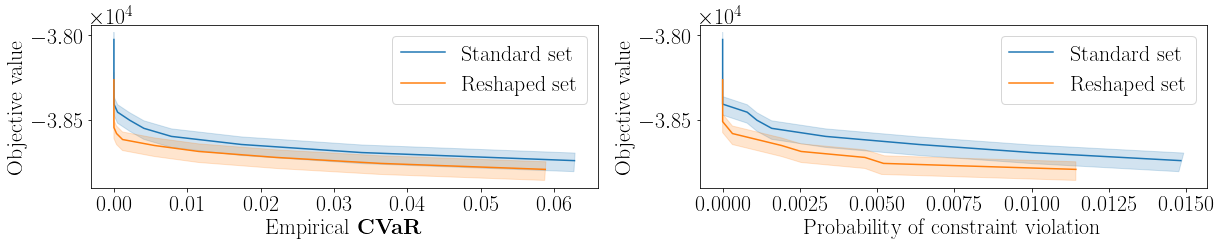

In [42]:
plot_tradeoff(dfgrid,dfgrid2,"inventory",ind_1 = (14,30), ind_2 = (24,40))

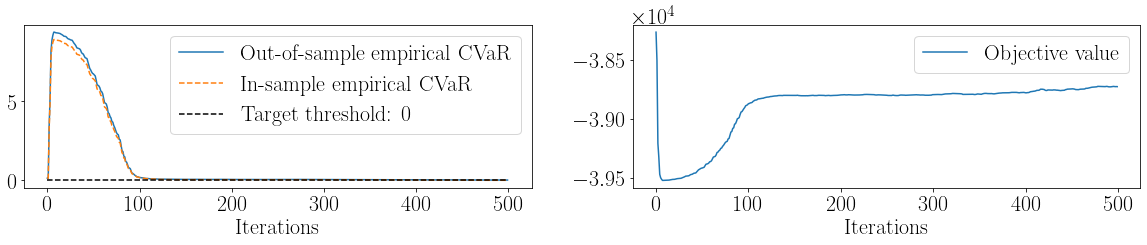

In [43]:
plot_iters(df1,"inventory")